## This notebook shows how to pretrain BERT and use it for text classification as a downstream task;
* I used the compute resources from Google Colab (awesome lads).

In [1]:
!pip install torch==1.9
!pip install torchtext==0.10

## Load necessary packages;

In [2]:
import bert_data_processing as bdp
import torch
from torch import nn
import bert
import transformer as tr
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from torchtext.datasets import AG_NEWS
mpl.style.use(["ggplot", "dark_background"])
np.random.seed(42)
torch.manual_seed(42)

## Load the training part of the AG_NEWS dataset so that I pretrain BERT on it;
* Note that the `max_len_consider` parameter is the maximum length of half a sentence, since for the Next Sentence Prediction pretraining task I basically split each sentence in two halves to mimic the sequential format;

In [3]:
batch_size, max_len_consider = 256, 50
loader, vocab = bdp.get_ag_news_loader_and_vocab(batch_size, max_len_consider, directory="../data", vocab_min_freq=5)

### Take a look at the format:
* Indexes of tokens;
* Segment indexes;
* Last index of seq to consider (i.e. don't consider pads);
* Indexes of masks (i.e. masked by <mask\> token, the original token or randomly sampled token);
* Masked-Language-Model weights - since we are padding only calculate loss for actual masks and not pads;
* The Next Sentence Prediction label (second sequence follows first or not);

In [4]:
print(loader.dataset[0])

(tensor([    3,   392,   330,  1538,     2,   103,    58,     5,   810,     2,
           27,     4,     0,   392,  1940, 10181,  3277,     8,     2,    38,
         3914,   744,   296,     4,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), tensor(24.), tensor([ 4,  9, 18,  0,  0,  0,  0,  0]), tensor([1., 1., 1., 0., 0., 0., 0., 0.]), tensor([14290,    27,     0,     0,     0,     0,     0,     0]), tensor(1))


In [5]:
print(vocab.convert_to_token(loader.dataset[0][0].tolist()))

['<cls>', 'wall', 'st', 'bears', '<mask>', 'back', 'into', 'the', 'black', '<mask>', 'reuters', '<sep>', '<unk>', 'wall', 'streets', 'dwindling', 'band', 'of', '<mask>', 'are', 'seeing', 'green', 'again', '<sep>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


### Get losses for MLM and NSP tasks;

In [6]:
loss_mlm = nn.CrossEntropyLoss(reduction="none")
loss_nsp = nn.CrossEntropyLoss()

### Instantiate BERT model;

In [7]:
vocab_size, hidden_dim, ffn_hidden, num_heads = len(vocab), 128, 256, 4
norm_dim, ffn_input, num_layers, dropout, with_bias = [128], 128, 4, 0.2, True

bert_model = bert.BertModel(hidden_dim, hidden_dim, hidden_dim, hidden_dim, num_heads,
                            norm_dim, ffn_input, ffn_hidden, num_layers, vocab_size, pos_encoding_size=1000,
                            mlm_input=hidden_dim, mlm_hiddens=2*hidden_dim, nsp_input=hidden_dim,
                            nsp_hidden=2*hidden_dim, dropout=dropout, with_bias=with_bias)

### Decide on device;

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"I will be using {device}.")

I will be using cuda.


### Move model to device;

In [9]:
bert_model.to(device)

BertModel(
  (encoder): BertEncoder(
    (word_embeds): Embedding(26320, 128)
    (segment_embeds): Embedding(2, 128)
    (encoders): Sequential(
      (encoder_block_0): EncoderBlock(
        (attention): MHAttention(
          (attention_pooling): LearnableDotProdAttention(
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (W_q): Linear(in_features=128, out_features=128, bias=True)
          (W_k): Linear(in_features=128, out_features=128, bias=True)
          (W_v): Linear(in_features=128, out_features=128, bias=True)
          (W_o): Linear(in_features=128, out_features=128, bias=True)
        )
        (add_norm1): AddNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (ffn): EncBlockFFN(
          (net): Sequential(
            (0): Linear(in_features=128, out_features=256, bias=True)
            (1): ReLU()
            (2): Linear(in_features=256, out_features=

### Get optimiser for the pretraining with scheduler to decrease learning rate by half after each epoch;

In [10]:
adam_optim = torch.optim.Adam(bert_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(adam_optim, step_size=1, gamma=0.75)

### Take a look at the output format of BERT;

In [11]:
with torch.no_grad():
  bert_model.eval()
  for (tokens, segments, attention_masks, masked_positions, weights_for_masks,
        original_labels_for_masks, nsp_labels) in loader:
      encodings, mlm_preds, nsp_preds = bert_model(tokens.to(device), segments.to(device), 
                                                    attention_masks.to(device), 
                                                    masked_positions.to(device))
      break

print(f"shape of encoding: {encodings.shape} --> (batch_size, seq_len, embed_size)")
print(f"shape of mlm_preds: {mlm_preds.shape} --> (batch_size, num_masks, vocab_size)")
print(f"shape of nsp_preds: {nsp_preds.shape} --> (batch_size, num_classes_to_predict)")

shape of encoding: torch.Size([256, 50, 128]) --> (batch_size, seq_len, embed_size)
shape of mlm_preds: torch.Size([256, 8, 26320]) --> (batch_size, num_masks, vocab_size)
shape of nsp_preds: torch.Size([256, 2]) --> (batch_size, num_classes_to_predict)


### Define how to combine losses from two pretrainig tasks;

In [12]:
def loss_per_batch(bert_model, loss_mlm, loss_nsp, vocab_size, tokens, segments,
                         attention_masks, masked_positions, weights_for_masks, 
                         original_labels_for_masks, nsp_labels):
    
    # effectively the forward pass;
    encodings, mlm_preds, nsp_preds = bert_model(tokens, segments,
                                          attention_masks, masked_positions)
    # Now get loss from MLM task;
    # it is important that the loss reduction is none, so that I can customize it a bit
    # by multiplying by weights so that I don't count the loss from <pad> tokens
    # when doing the MLM model;
    mlm_loss = loss_mlm(mlm_preds.reshape(-1, vocab_size), 
                    original_labels_for_masks.reshape(-1)) * weights_for_masks.reshape(-1)
    
    # now I can average the MLM loss over the weights;
    mlm_loss = mlm_loss.sum() / (weights_for_masks.sum() + 1e-9)
    
    # Now get the next sentence prediction loss;
    # here this is the default reduction for loss_nsp, i.e. averaged;
    nsp_loss = loss_nsp(nsp_preds, nsp_labels)
    
    # combine the two losses;
    sum_of_losses = mlm_loss + nsp_loss
    return mlm_loss, nsp_loss, sum_of_losses

### Define a training loop for one epoch;

In [13]:
def train_loop(bert_model, loss_nsp, loss_mlm, optim, loader, vocab):
  vocab_size = torch.tensor(len(vocab), device=device)
  bert_model.to(device)
  bert_model.train()
  fifth = max(1, len(loader) // 5)
  tot_loss_per_epoch = 0.
  tot_mlm_loss_per_epoch = 0.
  tot_nsp_loss_per_epoch = 0.
  size = len(loader.dataset)

  for batch, (tokens, segments, attention_masks, masked_positions, weights_for_masks,
         original_labels_for_masks, nsp_labels) in enumerate(loader, start=1):
        # forward pass on one batch plus calculating the loss(es);
        mlm_loss, nsp_loss, sum_of_losses = loss_per_batch(bert_model, loss_mlm, loss_nsp,
                                                          vocab_size, 
                                                           tokens.to(device), 
                                                           segments.to(device),
                                                          attention_masks.to(device), 
                                                           masked_positions.to(device),
                                                          weights_for_masks.to(device),
                                                          original_labels_for_masks.to(device), 
                                                           nsp_labels.to(device))
        if batch % fifth == 0:
          print(f"mlm_loss:  {mlm_loss:.5f}\tnsp_loss:  {nsp_loss:.5f}\tcombined_loss:  {sum_of_losses:.5f}\tprogress:  {batch}/{len(loader)}")
        tot_loss_per_epoch += sum_of_losses.item() * len(nsp_labels)
        tot_mlm_loss_per_epoch += mlm_loss.item() * len(nsp_labels)
        tot_nsp_loss_per_epoch += nsp_loss.item() * len(nsp_labels)
        # now for the backward pass;
        optim.zero_grad()
        sum_of_losses.backward()
        optim.step()
  print(f"mlm_loss_per_epoch:  {tot_mlm_loss_per_epoch/size:.5f}\tnsp_loss_per_epoch:  {tot_nsp_loss_per_epoch/size:.5f}\tcombined_loss_per_epoch:  {tot_loss_per_epoch/size:.5f}")
  return tot_mlm_loss_per_epoch/size, tot_nsp_loss_per_epoch/size, tot_loss_per_epoch/size        

### Start the pretraining procedure;
* The purpose here is to show that the current configuration "trains" since the loss falls;
* Obviously the choice of training for only 5 epochs is arbitrary and it is possible that different hyperparameter configuration may yield better results;

In [14]:
best_loss_pre = None

In [15]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}:\n----------------------------------------")
  mlm, nsp, combined = train_loop(bert_model, loss_nsp, loss_mlm, adam_optim, loader, vocab)
  print(f"last_lr: {scheduler.get_last_lr()[-1]:.5f}\n")
  scheduler.step()
  if best_loss_pre is None or combined < best_loss_pre:
    best_loss_pre = combined
    torch.save(bert_model.state_dict(), "bert_pretrained.pt")

Epoch 1:
----------------------------------------
mlm_loss:  7.77615	nsp_loss:  0.68801	combined_loss:  8.46416	progress:  85/429
mlm_loss:  7.63088	nsp_loss:  0.68875	combined_loss:  8.31963	progress:  170/429
mlm_loss:  7.60722	nsp_loss:  0.70110	combined_loss:  8.30833	progress:  255/429
mlm_loss:  7.46250	nsp_loss:  0.67030	combined_loss:  8.13280	progress:  340/429
mlm_loss:  7.37501	nsp_loss:  0.67108	combined_loss:  8.04609	progress:  425/429
mlm_loss_per_epoch:  7.64519	nsp_loss_per_epoch:  0.68582	combined_loss_per_epoch:  8.33101
last_lr: 0.00100

Epoch 2:
----------------------------------------
mlm_loss:  7.41116	nsp_loss:  0.65799	combined_loss:  8.06914	progress:  85/429
mlm_loss:  7.43081	nsp_loss:  0.65916	combined_loss:  8.08996	progress:  170/429
mlm_loss:  7.22762	nsp_loss:  0.63185	combined_loss:  7.85947	progress:  255/429
mlm_loss:  7.18296	nsp_loss:  0.63866	combined_loss:  7.82162	progress:  340/429
mlm_loss:  7.22548	nsp_loss:  0.60775	combined_loss:  7.83323	p

## Now doing the classification problem;
* First, load the "best" pretrained BERT;

In [16]:
vocab_size, hidden_dim, ffn_hidden, num_heads = len(vocab), 128, 256, 4
norm_dim, ffn_input, num_layers, dropout, with_bias = [128], 128, 4, 0.2, True

best_bert_pre = bert.BertModel(hidden_dim, hidden_dim, hidden_dim, hidden_dim, num_heads,
                            norm_dim, ffn_input, ffn_hidden, num_layers, vocab_size, pos_encoding_size=1000,
                            mlm_input=hidden_dim, mlm_hiddens=2*hidden_dim, nsp_input=hidden_dim,
                            nsp_hidden=2*hidden_dim, dropout=dropout, with_bias=with_bias)

In [17]:
best_bert_pre.load_state_dict(torch.load("bert_pretrained.pt"))

<All keys matched successfully>

In [18]:
best_bert_pre.to(device)

BertModel(
  (encoder): BertEncoder(
    (word_embeds): Embedding(26320, 128)
    (segment_embeds): Embedding(2, 128)
    (encoders): Sequential(
      (encoder_block_0): EncoderBlock(
        (attention): MHAttention(
          (attention_pooling): LearnableDotProdAttention(
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (W_q): Linear(in_features=128, out_features=128, bias=True)
          (W_k): Linear(in_features=128, out_features=128, bias=True)
          (W_v): Linear(in_features=128, out_features=128, bias=True)
          (W_o): Linear(in_features=128, out_features=128, bias=True)
        )
        (add_norm1): AddNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (ffn): EncBlockFFN(
          (net): Sequential(
            (0): Linear(in_features=128, out_features=256, bias=True)
            (1): ReLU()
            (2): Linear(in_features=256, out_features=

### Define classification head;

In [19]:
class ClassificationHead(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ClassificationHead, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.ln1 = nn.LayerNorm([hidden_dim])
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, output_dim)
  
  def forward(self, cls_token):
    out = self.ln1(self.linear1(cls_token))
    return self.linear2(self.relu(out))

### Prepare data for classification task for the AG_NEWS dataset;

In [20]:
train_iter, test_iter = AG_NEWS("../data", split=("train", "test"))

In [21]:
def clean_text(text):
    return re.sub("[^A-Za-z\s]+", '', re.sub("\\\\", ' ', text).strip()).lower()

In [22]:
# labels oddly start from 1 to 4, so subtract one to make them start from 0 to 3;
tuple_list_train = [(clean_text(text), num_label-1) 
                    for num_label, text in train_iter]
tuple_list_test = [(clean_text(text), num_label-1) 
                    for num_label, text in test_iter]

### Check out the distribution of sequence lengths in train set and test set, to pick a padding length;

In [23]:
train_lens = [len(text.split()) for text, _ in tuple_list_train]
test_lens = [len(text.split()) for text, _ in tuple_list_test]

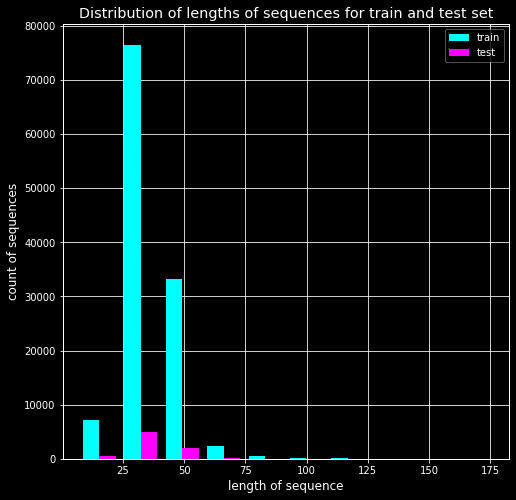

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(np.array([train_lens, test_lens], dtype="object"), color=["cyan", "magenta"], label=["train", "test"])
ax.legend()
ax.set_title("Distribution of lengths of sequences for train and test set")
ax.set_xlabel("length of sequence")
ax.set_ylabel("count of sequences")
plt.show()

### Seems len of 75 is ok for padding;

In [25]:
def get_tensors_from_strings(tuple_list, vocab, pad_len):
  padded_text = []
  all_segments = []
  all_attention_masks = []
  all_labels = []

  for text, label in tuple_list:
    tokenised = text.split()
    # since we will add <cls> and <sep> per sequence;
    if len(tokenised) + 2 <= pad_len and len(tokenised) > 0:
      tokenised, segments = bert.get_tokens_and_segments(tokenised)
      padded_text.append(
          torch.tensor(vocab[tokenised] + [0] * (pad_len - len(tokenised)), dtype=torch.long))
      all_segments.append(
          torch.tensor(segments + [0] * (pad_len - len(tokenised)), dtype=torch.long))
      all_attention_masks.append(torch.tensor(len(tokenised), dtype=torch.long))
      all_labels.append(torch.tensor(label, dtype=torch.long))

  return (padded_text, all_segments, 
          all_attention_masks, all_labels)

### Get Dataset objects;

In [26]:
class ClassificationDataset(torch.utils.data.Dataset):
  def __init__(self, tuple_list, vocab, pad_len, **kwargs):
    super(ClassificationDataset, self).__init__(**kwargs)
    (self.padded_text, self.all_segments, 
     self.all_attention_masks, self.all_labels) = get_tensors_from_strings(
         tuple_list, vocab, pad_len)
  
  def __len__(self):
    return len(self.all_labels)
  
  def __getitem__(self, idx):
    return (self.padded_text[idx], self.all_segments[idx],
            self.all_attention_masks[idx], self.all_labels[idx])

In [27]:
train_dataset = ClassificationDataset(tuple_list_train, vocab, pad_len=75)
test_dataset = ClassificationDataset(tuple_list_test, vocab, pad_len=75)

In [28]:
print(f"length of training dataset: {len(train_dataset)}\n")
print(f"length of testing dataset: {len(test_dataset)}\n")

length of training dataset: 119192

length of testing dataset: 7553



### Wrap DataLoader objects;

In [29]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Proceed with classification_loss;

In [30]:
classification_loss = nn.CrossEntropyLoss()

### Instantiate classification head object;

In [31]:
# there are only 4 classes;
head_input_dim, head_hidden_dim, head_output_dim, dropout = hidden_dim, hidden_dim, 4, 0.4
classification_head = ClassificationHead(head_input_dim, head_hidden_dim, head_output_dim)
classification_head.to(device)

ClassificationHead(
  (linear1): Linear(in_features=128, out_features=128, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=4, bias=True)
)

### Now get the optimiser that is going to optimise the parameters of the transformer and the classification head;

In [32]:
combined_adam = torch.optim.Adam(itertools.chain(best_bert_pre.parameters(), classification_head.parameters()),
                                 lr=1e-3)
combined_scheduler = torch.optim.lr_scheduler.StepLR(combined_adam, step_size=1, gamma=0.8)

### Define training loop and test loop for the text classification task (for AG_NEWS);

In [33]:
def combined_train_loop(bert_model, classification_head, loss_fn, optim, train_loader):
  tot_train_loss, fifth = 0., max(1, len(train_loader) // 5)
  size = len(train_loader.dataset)
  bert_model.train()
  classification_head.train()
  for batch, (padded_text, segments, attention_masks, labels) in enumerate(train_loader, start=1):
    encodings, _, _ = bert_model(padded_text.to(device), segments.to(device), 
                                 attention_masks.to(device))
    # classify from <cls> tokens;
    preds = classification_head(encodings[:, 0, :])
    loss = loss_fn(preds, labels.to(device))
    if batch % fifth == 0:
      print(f"train_loss: {loss.item():.5f}\tprogress: {batch}/{len(train_loader)}")
    tot_train_loss += loss.item() * len(labels)

    # backward pass;
    optim.zero_grad()
    loss.backward()
    optim.step()
  print(f"avg_train_loss: {tot_train_loss/size:.5f}")
  return tot_train_loss/size

In [34]:
def combined_test_loop(bert_model, classification_head, loss_fn, test_loader):
  correct, size = 0., len(test_loader.dataset)
  tot_test_loss = 0.
  bert_model.eval()
  classification_head.eval()

  with torch.no_grad():
    for padded_text, segments, attention_masks, labels in test_loader:
      encodings, _, _ = bert_model(padded_text.to(device), segments.to(device), 
                                 attention_masks.to(device))
      # classify from <cls> tokens;
      preds = classification_head(encodings[:, 0, :])
      loss = loss_fn(preds, labels.to(device))
      tot_test_loss += loss.item() * len(labels)
      correct += (preds.argmax(1) == labels.to(device)).sum().item()
    print(f"avg_test_loss: {tot_test_loss/size:.5f}\ttest_accuracy: {correct/size:.5f}")
    return tot_test_loss/size, correct/size

### Train and evaluate;

In [35]:
best_test_loss = None

In [36]:
epochs = 8
for t in range(epochs):
  print(f"Epoch {t+1}:\n-----------------------------------")
  train_loss = combined_train_loop(best_bert_pre, classification_head, 
                                   classification_loss, combined_adam, train_loader)
  test_loss, test_accuracy = combined_test_loop(best_bert_pre, classification_head,
                                                classification_loss, test_loader)
  print(f"last_lr: {combined_scheduler.get_last_lr()[-1]:.5f}\n")
  combined_scheduler.step()
  if best_test_loss is None or test_loss < best_test_loss:
    torch.save(best_bert_pre.state_dict(), "best_bert_classification.pt")
    torch.save(classification_head.state_dict(), "best_classifier_head.pt")

Epoch 1:
-----------------------------------
train_loss: 0.65715	progress: 93/466
train_loss: 0.53230	progress: 186/466
train_loss: 0.50557	progress: 279/466
train_loss: 0.45116	progress: 372/466
train_loss: 0.47890	progress: 465/466
avg_train_loss: 0.59113
avg_test_loss: 0.43842	test_accuracy: 0.84258
last_lr: 0.00100

Epoch 2:
-----------------------------------
train_loss: 0.33530	progress: 93/466
train_loss: 0.37243	progress: 186/466
train_loss: 0.34626	progress: 279/466
train_loss: 0.41908	progress: 372/466
train_loss: 0.31255	progress: 465/466
avg_train_loss: 0.40237
avg_test_loss: 0.37242	test_accuracy: 0.87065
last_lr: 0.00080

Epoch 3:
-----------------------------------
train_loss: 0.23050	progress: 93/466
train_loss: 0.27916	progress: 186/466
train_loss: 0.28983	progress: 279/466
train_loss: 0.36546	progress: 372/466
train_loss: 0.24965	progress: 465/466
avg_train_loss: 0.33241
avg_test_loss: 0.32361	test_accuracy: 0.88839
last_lr: 0.00064

Epoch 4:
-------------------------

### Summary:
* So this ended up being a bit of a proof of concept, that this *from-scratch* model works. I reached **90%** accuracy on a balanced test_set with relatively low computational demands.
* However, more importantly for myself was that my weird idea of splitting each sentence in halves to "fool" **BERT** to treat the halves as sentences for the Next Sentence Prediction pretraining task seems to have yielded good results.
* This was an idea that intuitively made sense to me, but now there are also some empirical arguments in favour of it.